# Привлекательность и уровень заработной платы

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
data = pd.read_csv('beauty.csv', sep=';')

## Постановка задачи

По 1260 опрошенным имеются следующие данные:  

- заработная плата за час работы, $;  
- опыт работы, лет;  
- образование, лет;  
- внешняя привлекательность, в баллах от 1 до 5;  
- бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).
Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.  

Попарные диаграммы рассеяния всех количественных признаков:

In [28]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


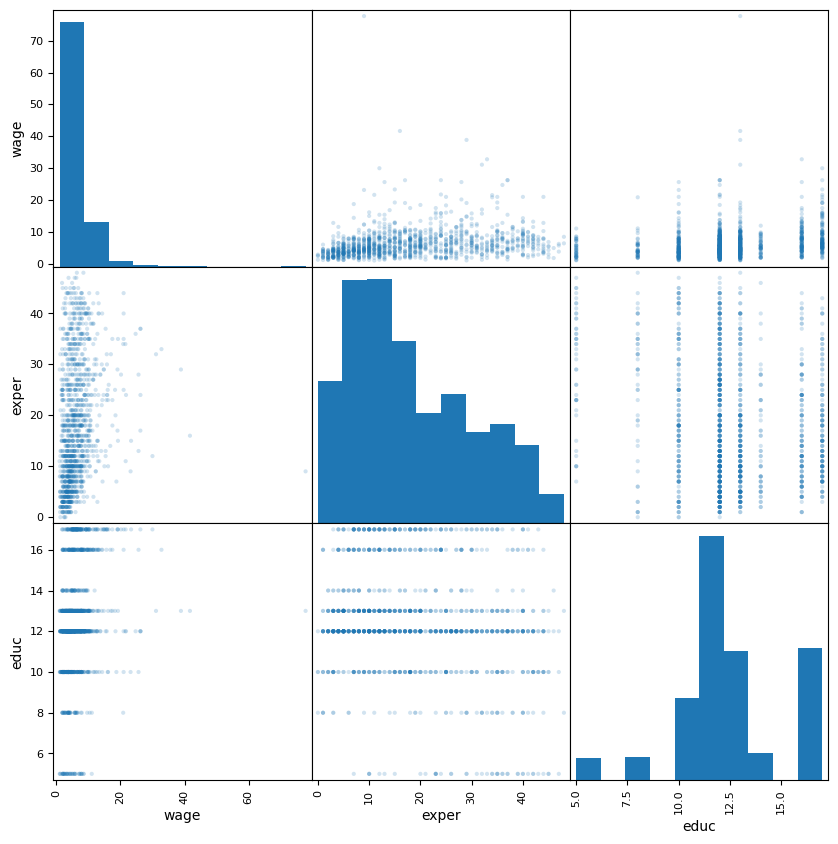

In [29]:
data.columns = ['wage', 'exper', 'union', 'goodhlth', 'black', 'female', 'married',
       'service', 'educ', 'looks']
data_signs = data[['wage', 'exper', 'educ']].copy()
pd.plotting.scatter_matrix(data_signs, alpha=0.2, figsize=(10,10));

## Задание

Как уровень внешней привлекательности влияет на средний уровень заработной платы с учетом остальных факторов?

### Предобработка

Посмотрите на распределение оценок привлекательности (looks). Сделайте из него категориальный признак, разбив на три категории (низкая привлекательность (looks < 3), средняя привлекательность (looks = 3) и высокая привлекательность (looks > 3))

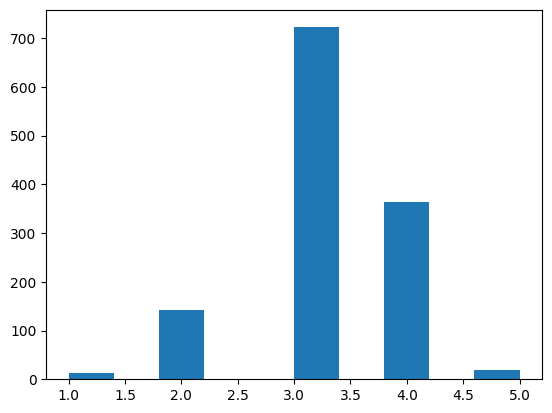

In [30]:
plt.hist(data.looks);

In [31]:
data['belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

In [32]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


Посмотрите на распределение значений отклика. Есть ли в нем выбросы? Выбросы могут сильно влиять на коэффициенты регрессии и мы с вами еще рассмотрим способы выявления выбросов. Удалите наблюдения, которые вы считаете выбросами. Этот шаг нужно всегда делать осторожно, но в этих данных выбросы видны невооруженным взглядом.

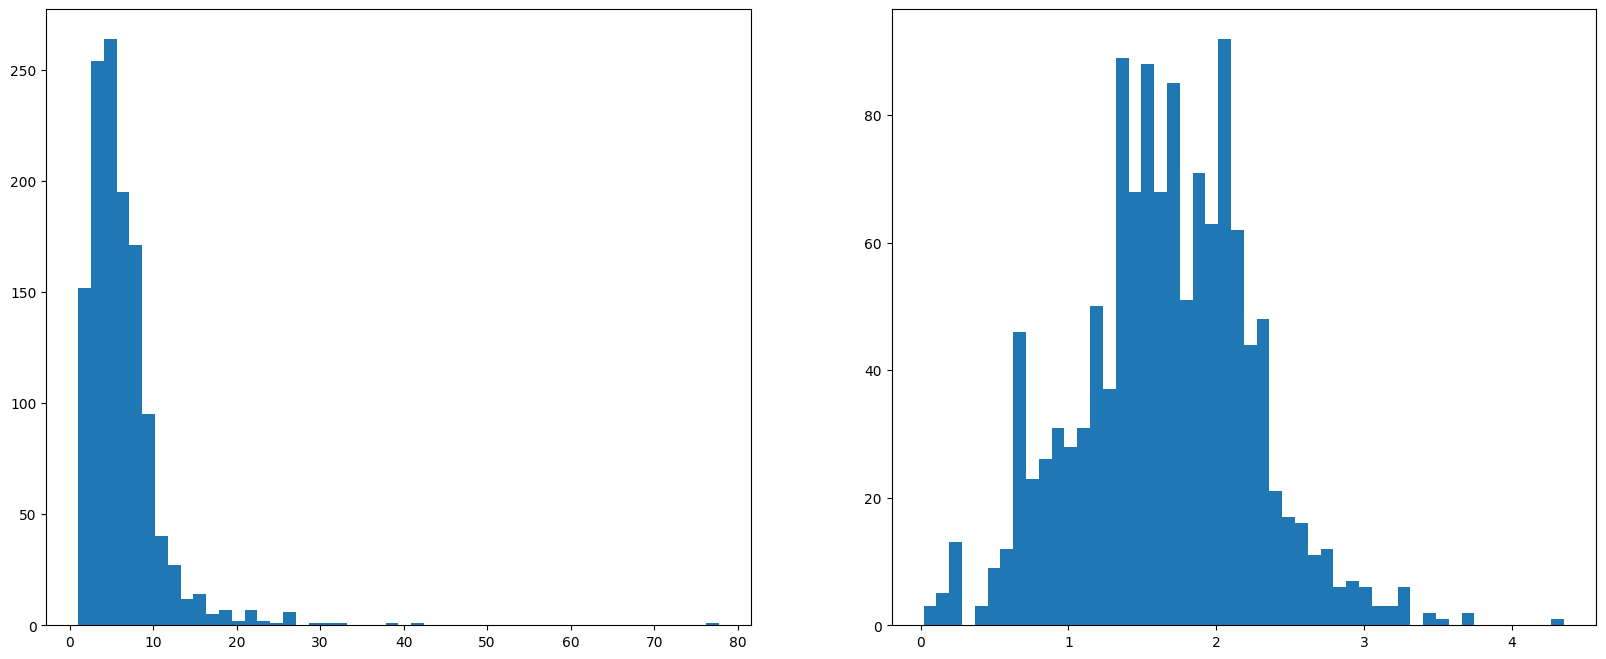

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))
ax1.hist(data['wage'], bins = 50)
ax2.hist(np.log(data['wage']), bins = 50)
plt.show()

Один человек в выборке получает 77.72\\$ в час, остальные - меньше 45\\$; удалим этого человека.

In [34]:
excluded = data[data['wage'] > 45]
data = data[data['wage'] < 45]

Видно, что распределение откликов далеко от нормального, поэтому примените пробразование Бокса-Кокса с помощью функции `boxcox` из `scipy`. Преобразуйте отклик согласно той трансформации, которую вы получите в результате выполнения этой функции.

In [35]:
from scipy import stats

In [36]:
print ('Box-Cox transformation: lambda=%f' %stats.boxcox(data_signs['wage'])[1])

Box-Cox transformation: lambda=-0.040531


Text(0.5, 0, '')

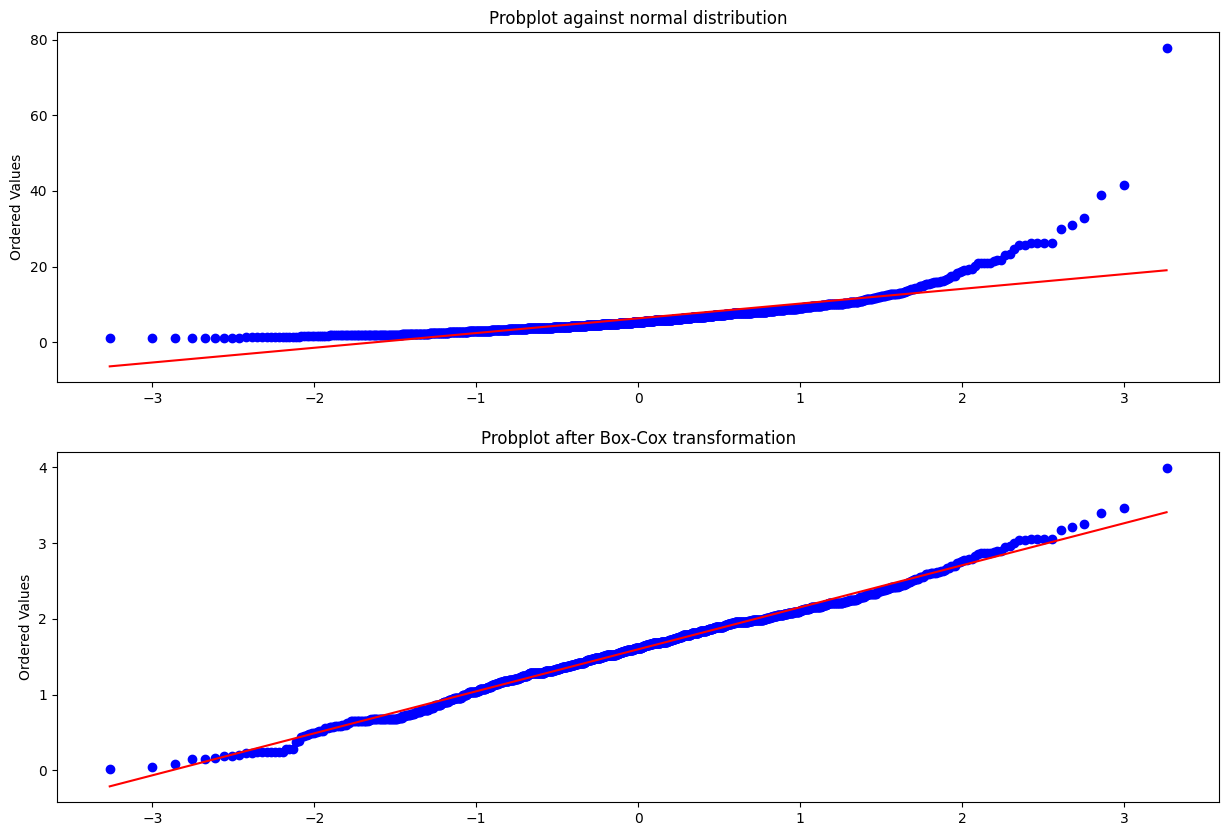

In [37]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
x = data_signs['wage']
stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax2.set_xlabel('')

Text(0.5, 0, '')

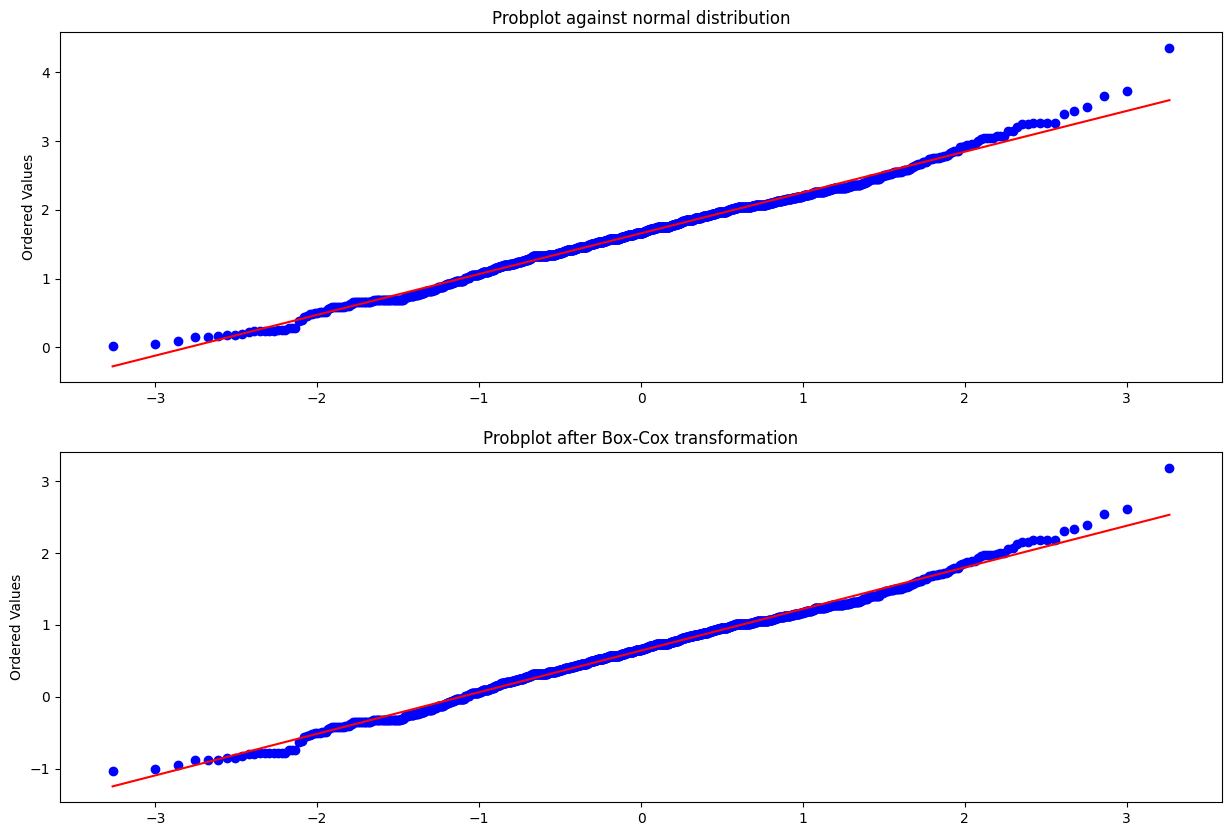

In [38]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
x = np.log(data_signs['wage'])
stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax2.set_xlabel('')

Будем строить регрессию логарифма отклика

### Модель 1

Постройте линейную регрессию по всем признакам, используя преобразованные значения отклика. Посмотрите на остатки регрессии c помощью метода `resid` результа работы функции `sm.ols`.

- Проверьте остатки на нормальность с помощью критерия Шапиро-Уилка.  

    - Если гипотеза нормальности отвергается, то для проверки несмещенности воспользуейтесь критерием знаковых рангов Уилкоксона (`wilcox`).  

    - Если гипотеза нормальности не отвергается, то воспользуйтесь критерием Стьюдента.

- С помощью критерия Бройша-Пагана (`het_breuschpagan` из `statsmodels`) проверьте модель на наличие гетероскедастичности.

In [39]:
import statsmodels.formula.api as smf

In [40]:
m1 = smf.ols('np.log(wage) ~ exper ', data=data)
result_m1 = m1.fit()
result_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     135.5
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           8.11e-30
Time:                        19:05:11   Log-Likelihood:                -1056.9
No. Observations:                1259   AIC:                             2118.
Df Residuals:                    1257   BIC:                             2128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3766      0.029     47.820      0.000       1.320       1.433
exper          0.0154      0.001     11.641      0.000       0.013       0.018
==============================================================================
Omnibus:                        5.623   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                6.942
Skew:                          -0.020   Prob(JB):                       0.0311
Kurtosis:                       3.362   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
m1 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female +'
                    'married + service + educ + belowavg + aboveavg', data=data)
result_m1 = m1.fit()
result_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          1.18e-123
Time:                        19:05:11   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.000       0.265       0.639
exper          0.0138      0.001     11.546      0.000       0.011       0.016
union          0.1785      0.030      5.957      0.000       0.120       0.237
goodhlth       0.0785      0.053      1.470      0.142      -0.026       0.183
black         -0.0989      0.052     -1.913      0.056      -0.200       0.003
female        -0.3938      0.031    -12.684      0.000      -0.455      -0.333
married        0.0425      0.031      1.383      0.167      -0.018       0.103
service       -0.1505      0.032     -4.656      0.000      -0.214      -0.087
educ           0.0799      0.005     14.581      0.000       0.069       0.091
belowavg      -0.1305      0.041     -3.148      0.002      -0.212      -0.049
aboveavg      -0.0041      0.030     -0.138      0.890      -0.063       0.055
==============================================================================
Omnibus:                       27.318   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.550
Skew:                           0.159   Prob(JB):                     7.80e-11
Kurtosis:                       3.887   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Остатки ненормальны, поэтому для проверки несмещённости используем критерий знаковых рангов Уилкоксона, и гетероскедастичны, поэтому оценку значимости признаков будем делать с дисперсиями Уайта; также будем делать поправку на множественность.

In [42]:
import statsmodels.stats.diagnostic as sms

In [43]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m1.resid, result_m1.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m1.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m1.resid)[1])

Breusch-Pagan test: p=0.000076
Shapiro-Wilk test: p=0.000001
Wilcoxon test: p=0.941618


Text(0.5, 1.0, 'log(residuals)')

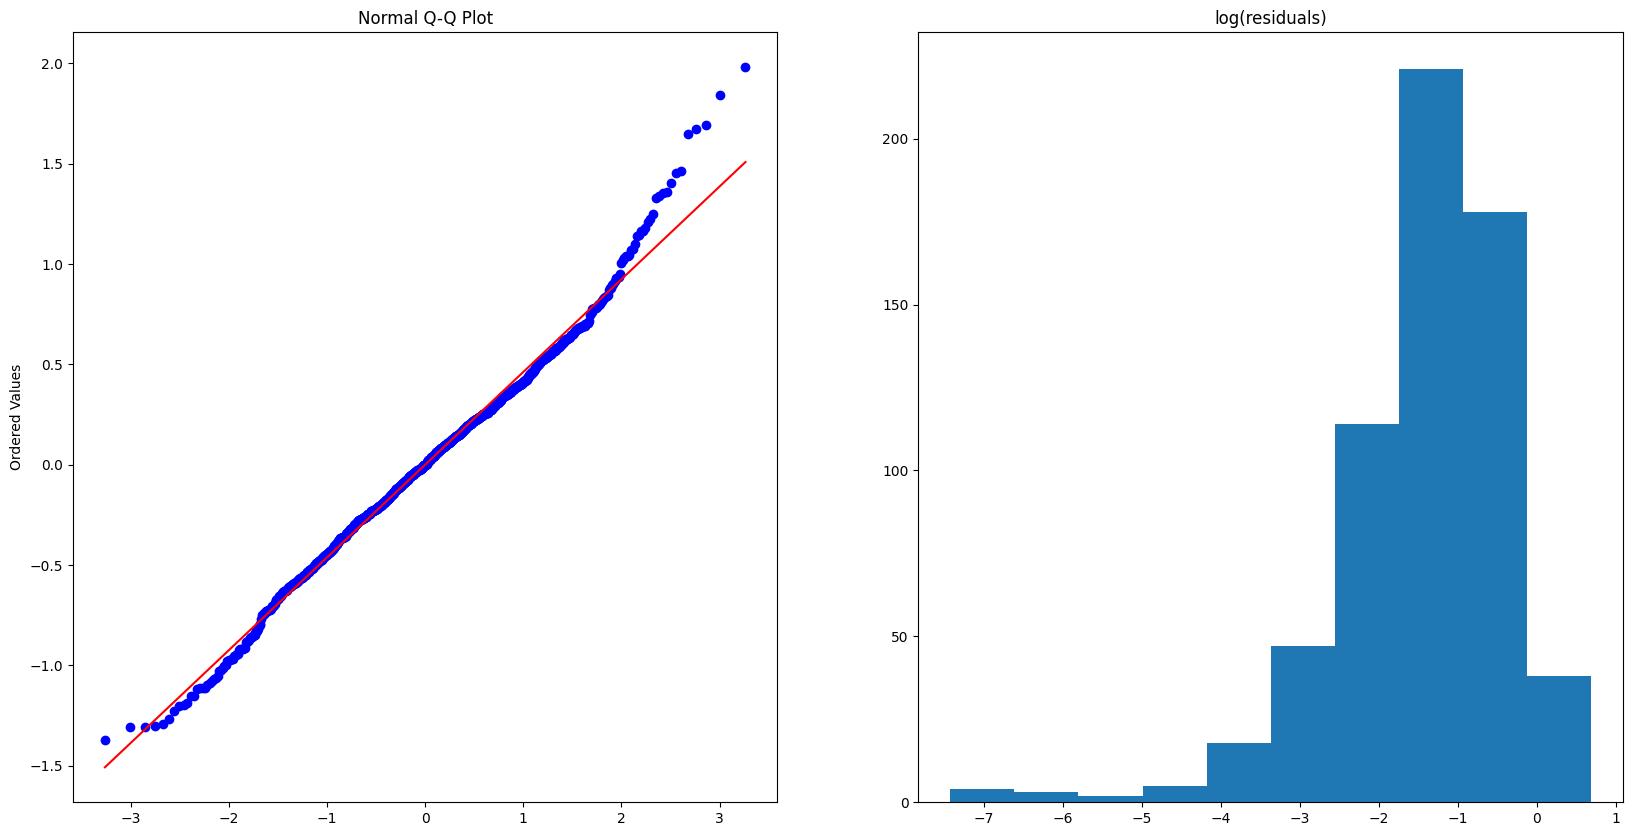

In [44]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m1.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m1.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

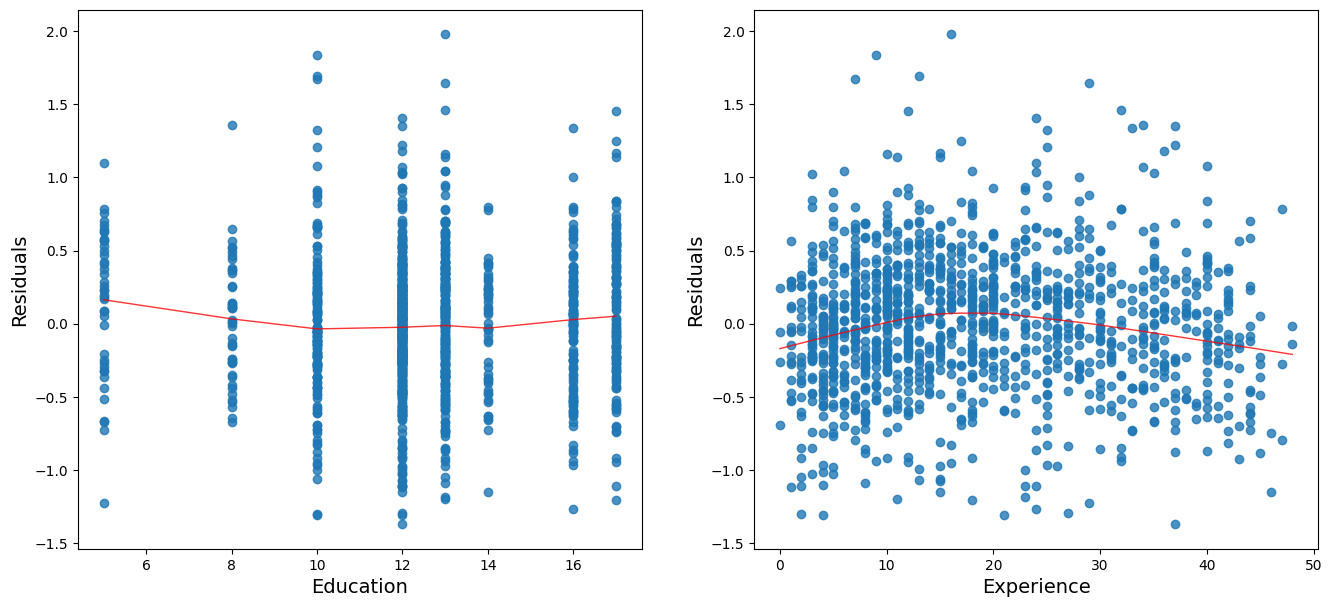

In [61]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(x=data['educ'],y=result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(x=data['exper'],y=result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

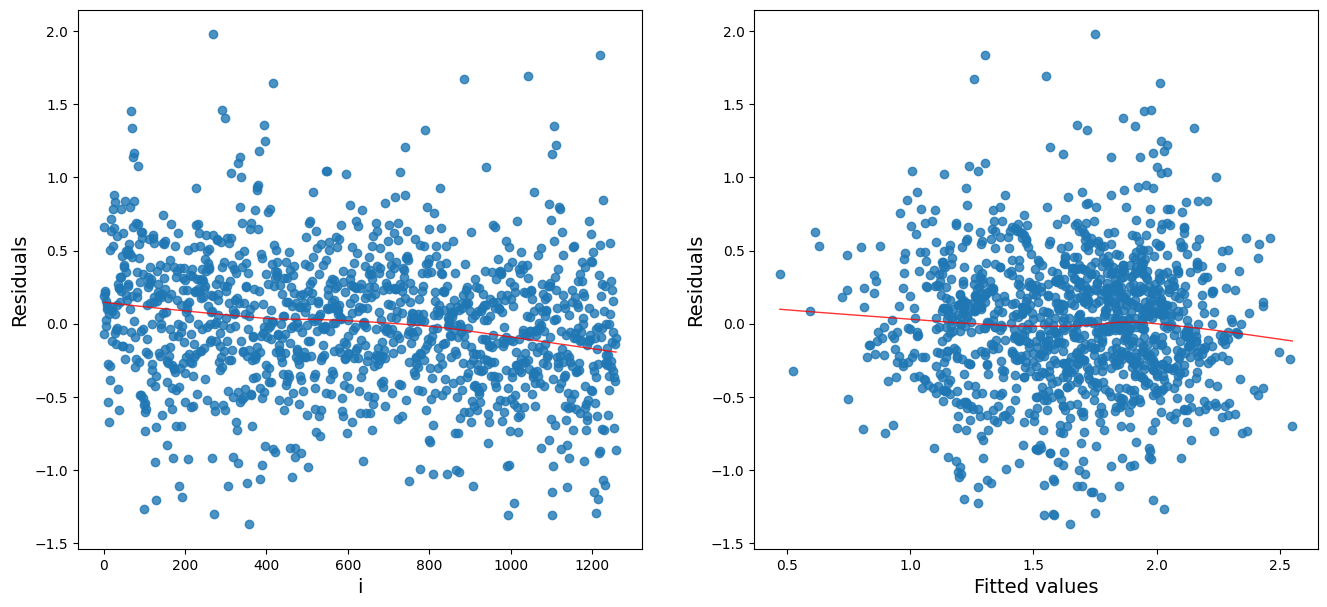

In [60]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(x=np.array(range(len(result_m1.resid))),y=result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(x=result_m1.predict(),y=result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


В остатках наблюдается квадратичная зависимость от опыта работы.

### Модель 2

Добавьте в линейную модель новый признак - квадрат опыта работы.

In [62]:
m2 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'
                            'married + service + educ + belowavg + aboveavg', data=data)
result_m2 = m2.fit(cov_type='HC1')
result_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          4.23e-146
Time:                        19:18:51   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0.104      3.282      0.001       0.138       0.547
exper                  0.0404      0.004      9.511      0.000       0.032       0.049
np.power(exper, 2)    -0.0006   9.46e-05     -6.469      0.000      -0.001      -0.000
union                  0.1710      0.026      6.463      0.000       0.119       0.223
goodhlth               0.0716      0.064      1.123      0.262      -0.053       0.197
black                 -0.0831      0.052     -1.599      0.110      -0.185       0.019
female                -0.3936      0.031    -12.702      0.000      -0.454      -0.333
married                0.0101      0.030      0.340      0.734      -0.048       0.068
service               -0.1599      0.033     -4.786      0.000      -0.225      -0.094
educ                   0.0758      0.006     13.387      0.000       0.065       0.087
belowavg              -0.1352      0.040     -3.384      0.001      -0.214      -0.057
aboveavg              -0.0025      0.030     -0.083      0.934      -0.061       0.056
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.257
Skew:                           0.140   Prob(JB):                     6.08e-13
Kurtosis:                       3.997   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m2.resid, result_m2.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m2.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m2.resid)[1])

Breusch-Pagan test: p=0.000004
Shapiro-Wilk test: p=0.000000
Wilcoxon test: p=0.961801


Text(0, 0.5, 'Residuals')

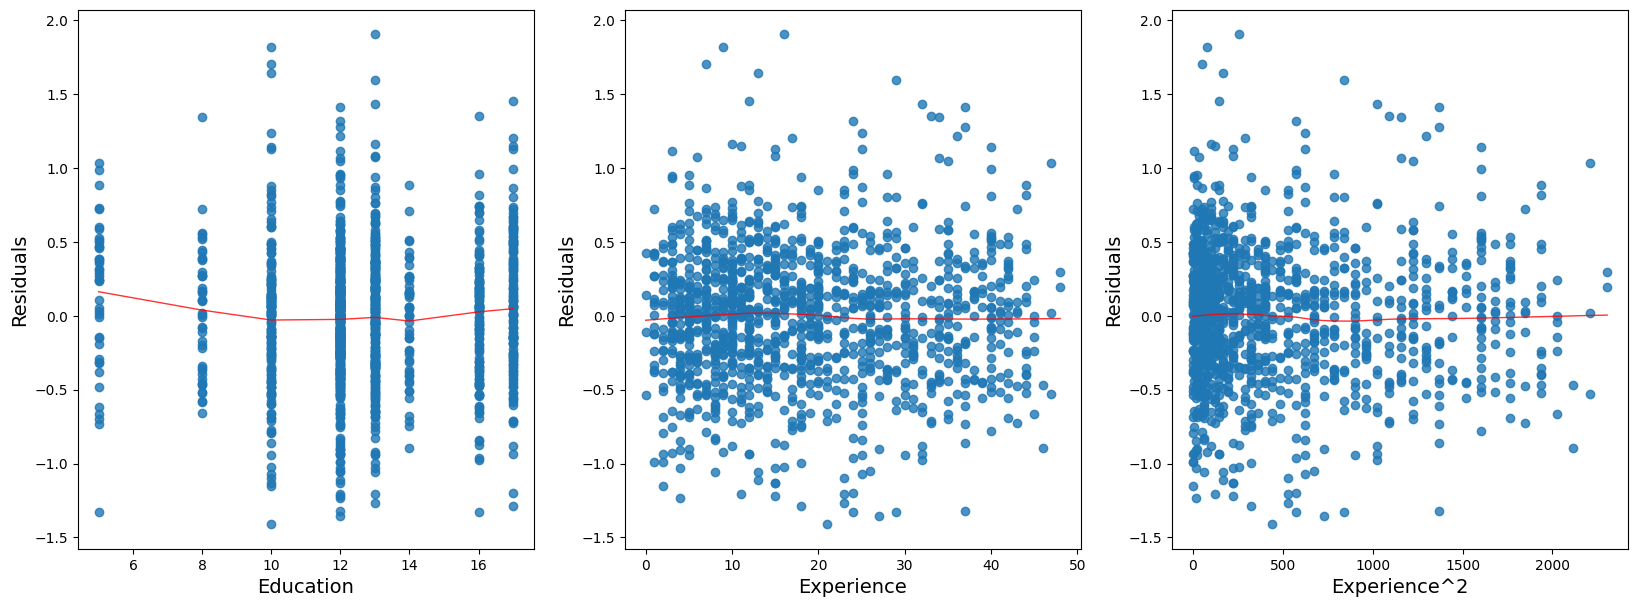

In [64]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.regplot(x=data['educ'],y=result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
sns.regplot(x=data['exper'],y=result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
sns.regplot(x=data['exper']**2,y=result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

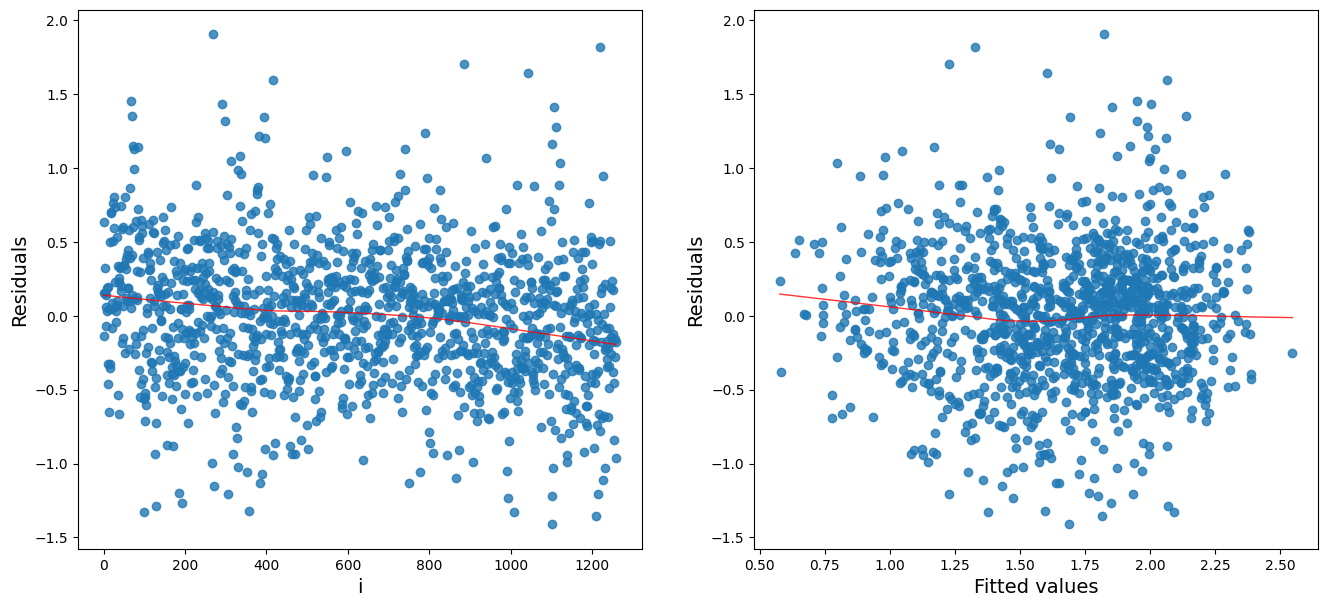

In [65]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(x=np.array(range(len(result_m2.resid))),y=result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(x=result_m2.fittedvalues, y=result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


Итоговая модель объясняет 39% вариации логарифма отклика.

Проведите визуальный анализ нормальности остатков и зависимостей остатков от каждого из признаков в модели, которую вы построили. Можно ли еще добавить какие-либо преобразования признаков, которые улучшат эти зависимости?

## Выводы

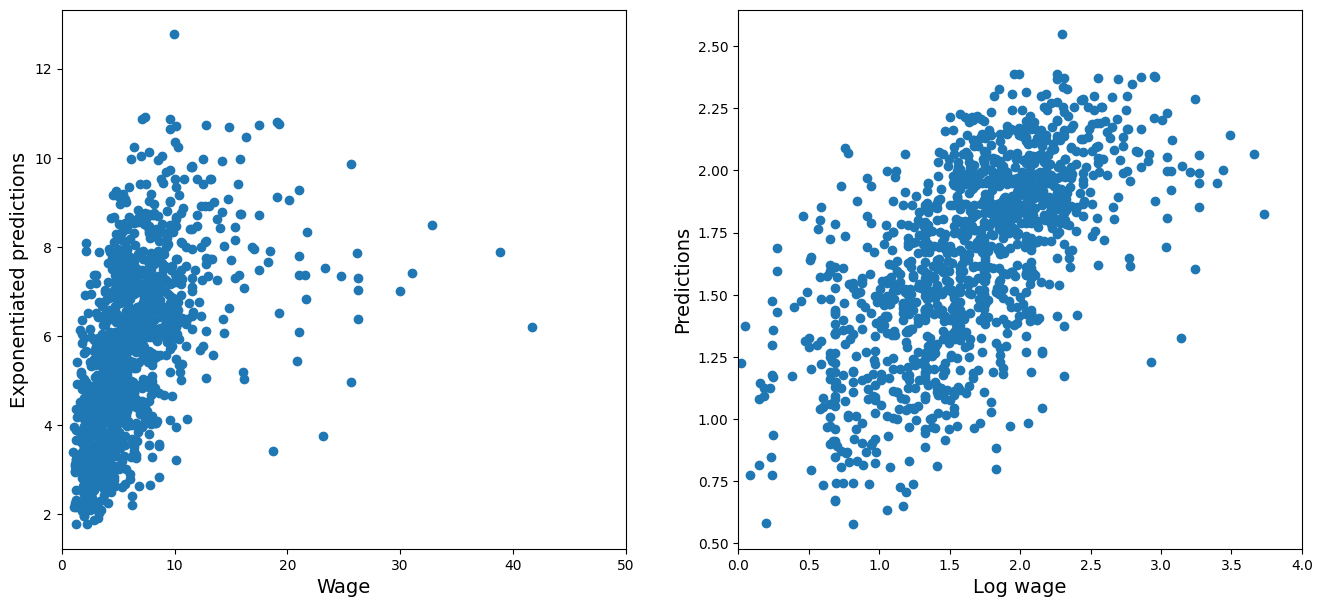

In [66]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(data['wage'],np.exp(result_m2.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
plt.scatter(np.log(data['wage']),result_m2.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
plt.show()

При интересующих нас факторах привлекательности стоят коэффициенты -0.1352 (ниже среднего) и -0.0025 (выше среднего). Однако привлекательность выше среднего не является значимым признаком.

Поскольку регрессия делалась на логарифм отклика, интерпретировать их можно как прирост в процентах. С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают в среднем на 13% меньше, если их привлекательность ниже среднего (p=0.001, 95% доверительный интервал — [5,21]%);

### Модель 3

Удалим из модели 2 незначимые признаки и добавим межфакторное взаимодействие занятости в сфере обслуживания и опыта работы.

In [67]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union  + female +'
                            ' service + educ + belowavg + exper*service', data=data)
result_m3 = m3.fit(cov_type='HC1')
result_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     121.6
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          2.09e-150
Time:                        19:19:42   Log-Likelihood:                -796.84
No. Observations:                1259   AIC:                             1612.
Df Residuals:                    1250   BIC:                             1658.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3503      0.084      4.155      0.000       0.185       0.516
exper                  0.0428      0.004     10.005      0.000       0.034       0.051
np.power(exper, 2)    -0.0006    9.3e-05     -6.892      0.000      -0.001      -0.000
union                  0.1666      0.027      6.276      0.000       0.115       0.219
female                -0.4064      0.030    -13.616      0.000      -0.465      -0.348
service               -0.0616      0.055     -1.124      0.261      -0.169       0.046
educ                   0.0784      0.006     13.775      0.000       0.067       0.090
belowavg              -0.1292      0.039     -3.330      0.001      -0.205      -0.053
exper:service         -0.0057      0.003     -2.114      0.035      -0.011      -0.000
==============================================================================
Omnibus:                       26.676   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.930
Skew:                           0.128   Prob(JB):                     3.91e-11
Kurtosis:                       3.921   Cond. No.                     4.55e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Значимы все признаки, кроме индикатора привлекательности выше среднего.

In [68]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m3.resid, result_m3.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m3.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m3.resid)[1])

Breusch-Pagan test: p=0.000004
Shapiro-Wilk test: p=0.000001
Wilcoxon test: p=0.958960


Text(0.5, 1.0, 'log(residuals)')

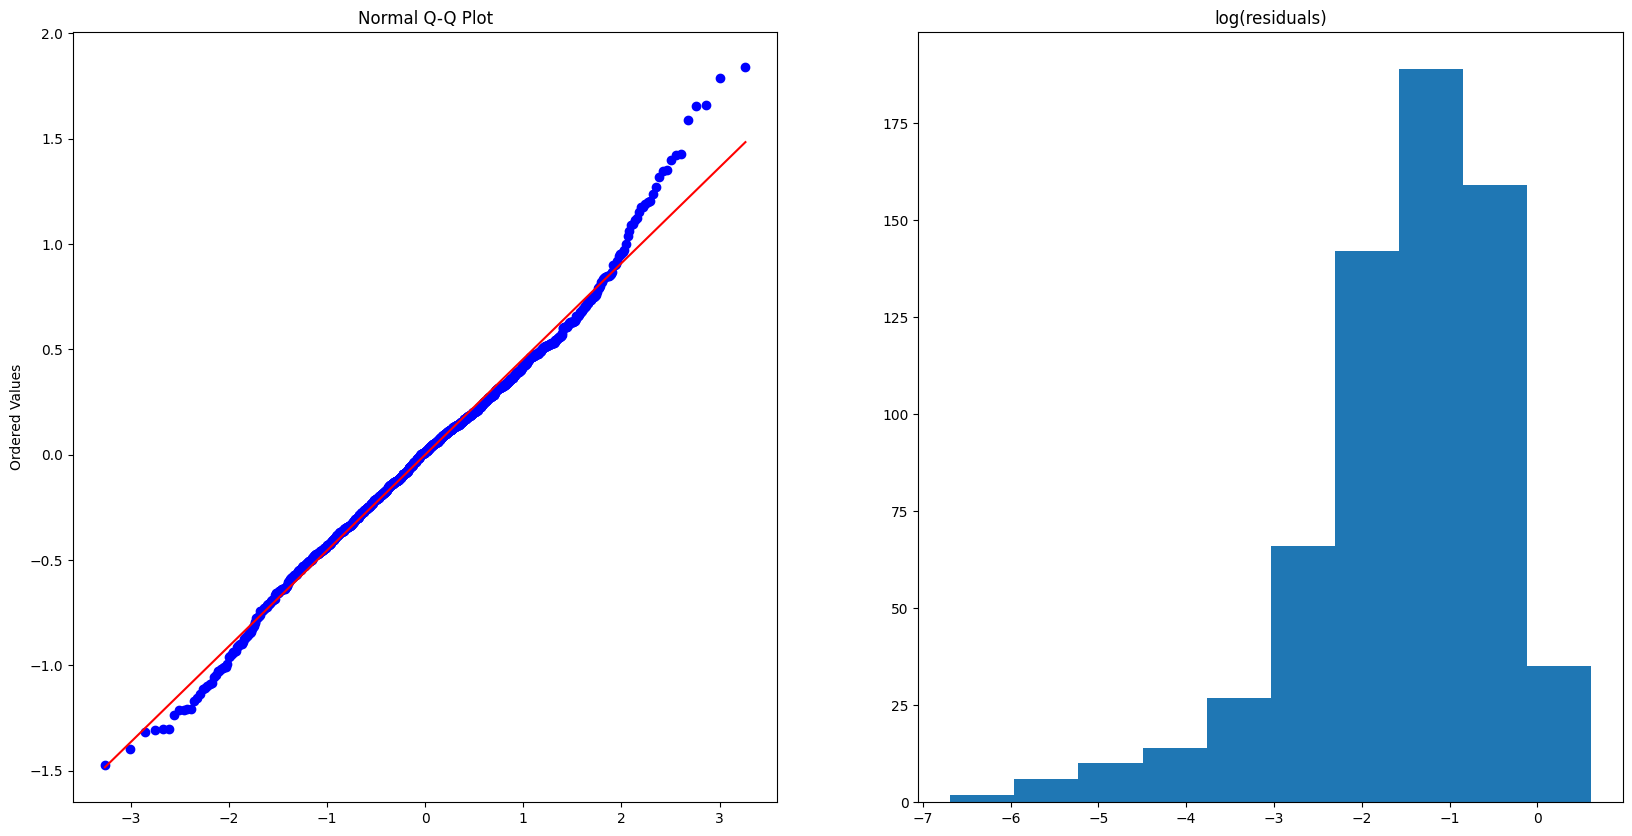

In [69]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m3.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m3.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

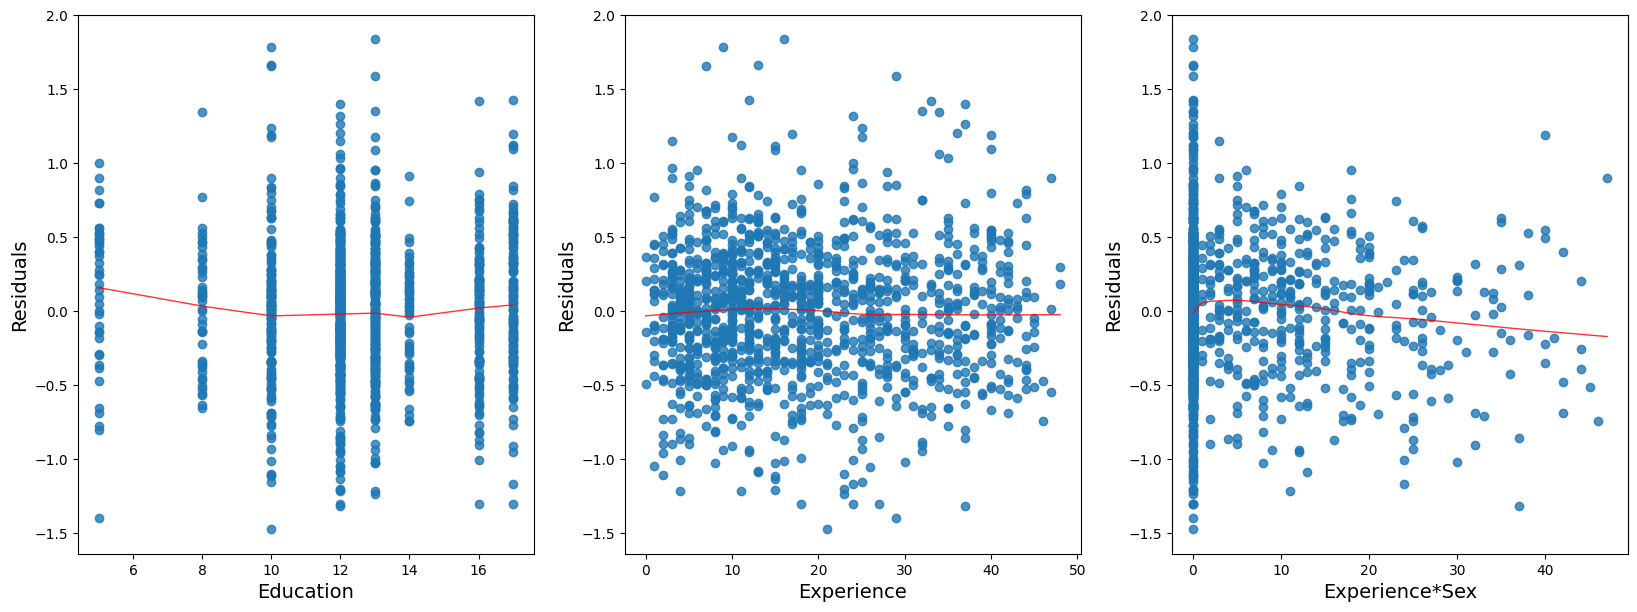

In [71]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.regplot(x=data['educ'],y=result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
sns.regplot(x=data['exper'],y=result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
sns.regplot(x=data['exper']*data['female'],y=result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience*Sex', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

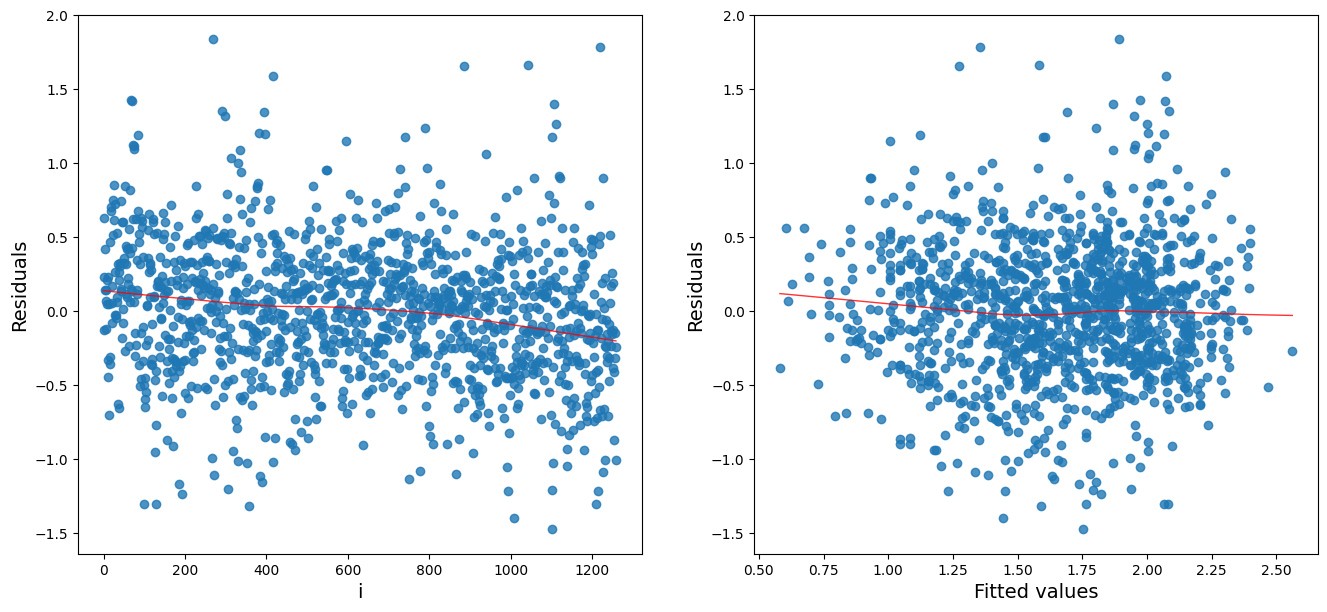

In [72]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(x=np.array(range(len(result_m3.resid))),y=result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(x=result_m3.fittedvalues,y=result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

$H_0$: добавление второй модели не имеет эффекта (не дает существенного улучшения)

Критерий Давидсона-Маккинона показывает, что модель ни одна из моделей не лучше другой.

In [73]:
print ('m3 + fitted(m2):  t-value=%f,  Pr(>|t|)=%f' % sms.compare_j(result_m3,result_m2))
print ('m2 + fitted(m3):  t-value=%f,  Pr(>|t|)=%f' % sms.compare_j(result_m2, result_m3))

m3 + fitted(m2):  t-value=2.118222,  Pr(>|t|)=0.034354
m2 + fitted(m3):  t-value=2.105218,  Pr(>|t|)=0.035472


Попробуем сконструировать новую.

## Модель 4

Попробуем оставить в модели 2 цвет кожи и семейное положение, чтобы добавить их взаимодействия с полом. Как и в модели 3, добавим взаимодействие занятости в сфере обслуживания с опытом работы, а состояние здоровья удалим.

In [75]:
m4 = smf.ols('np.log(wage) ~ exper + exper *  service+'
             'female + black + female * black + married + female * married +'
             'union + service + educ + aboveavg + belowavg + np.power(exper,2)', data=data)
result_m4 = m4.fit(cov_type='HC1')
result_m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     78.46
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          1.72e-151
Time:                        19:20:49   Log-Likelihood:                -784.21
No. Observations:                1259   AIC:                             1596.
Df Residuals:                    1245   BIC:                             1668.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3352      0.087      3.839      0.000       0.164       0.506
exper                  0.0408      0.004      9.405      0.000       0.032       0.049
service               -0.0641      0.055     -1.175      0.240      -0.171       0.043
exper:service         -0.0056      0.003     -2.075      0.038      -0.011      -0.000
female                -0.3103      0.048     -6.442      0.000      -0.405      -0.216
black                 -0.2451      0.073     -3.380      0.001      -0.387      -0.103
female:black           0.3165      0.099      3.205      0.001       0.123       0.510
married                0.0904      0.041      2.223      0.026       0.011       0.170
female:married        -0.1891      0.057     -3.303      0.001      -0.301      -0.077
union                  0.1730      0.026      6.548      0.000       0.121       0.225
educ                   0.0765      0.006     13.635      0.000       0.066       0.088
aboveavg               0.0014      0.029      0.048      0.961      -0.056       0.059
belowavg              -0.1306      0.040     -3.288      0.001      -0.208      -0.053
np.power(exper, 2)    -0.0006   9.37e-05     -6.496      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       25.411   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.253
Skew:                           0.131   Prob(JB):                     2.46e-10
Kurtosis:                       3.880   Cond. No.                     6.65e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'log(residuals)')

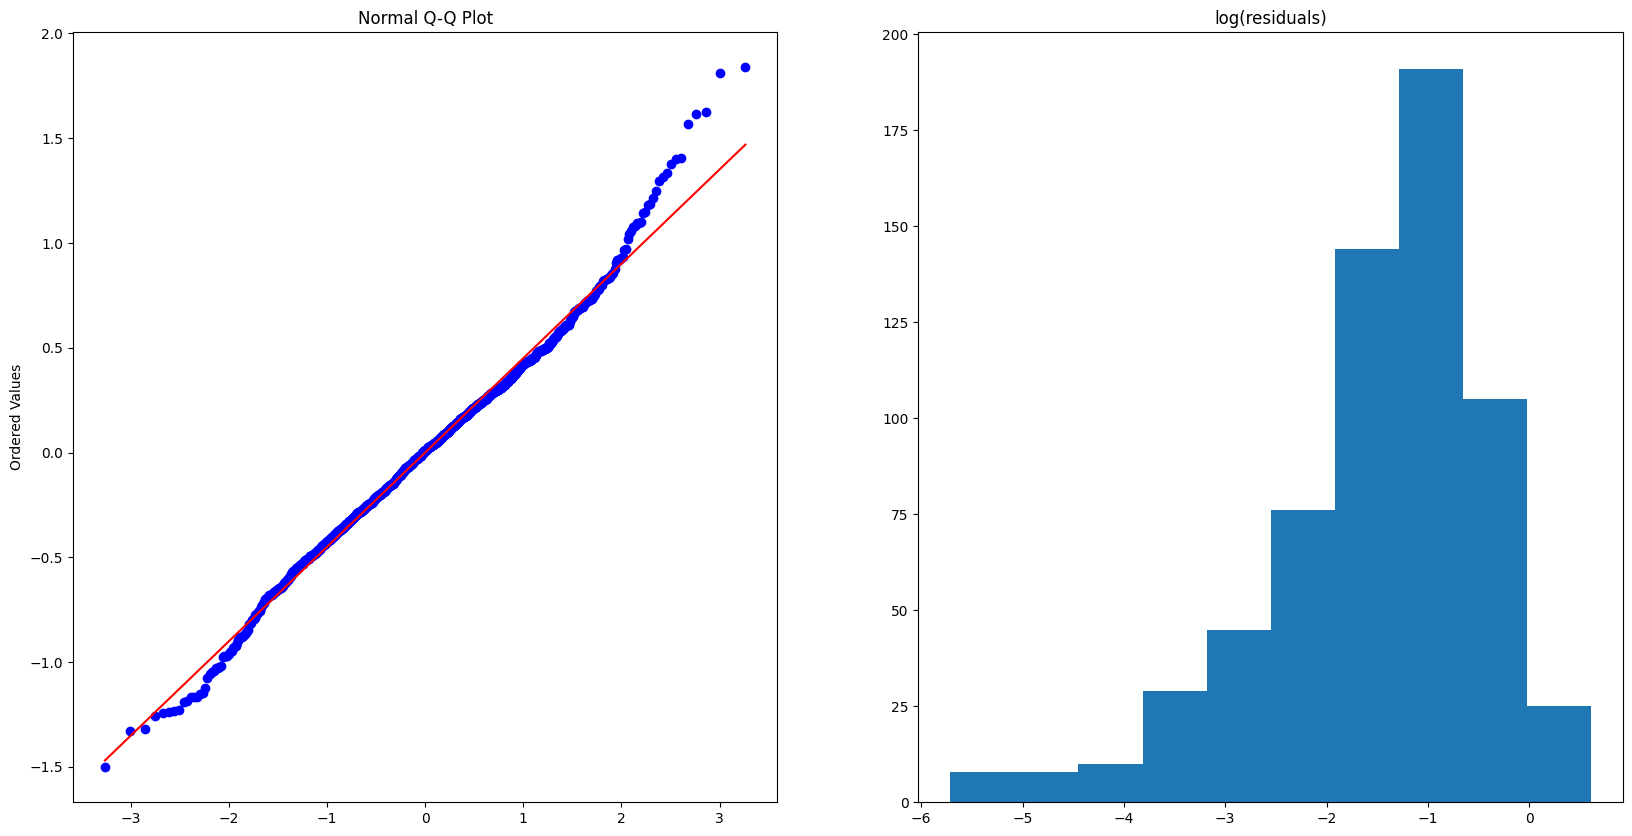

In [76]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m4.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m4.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

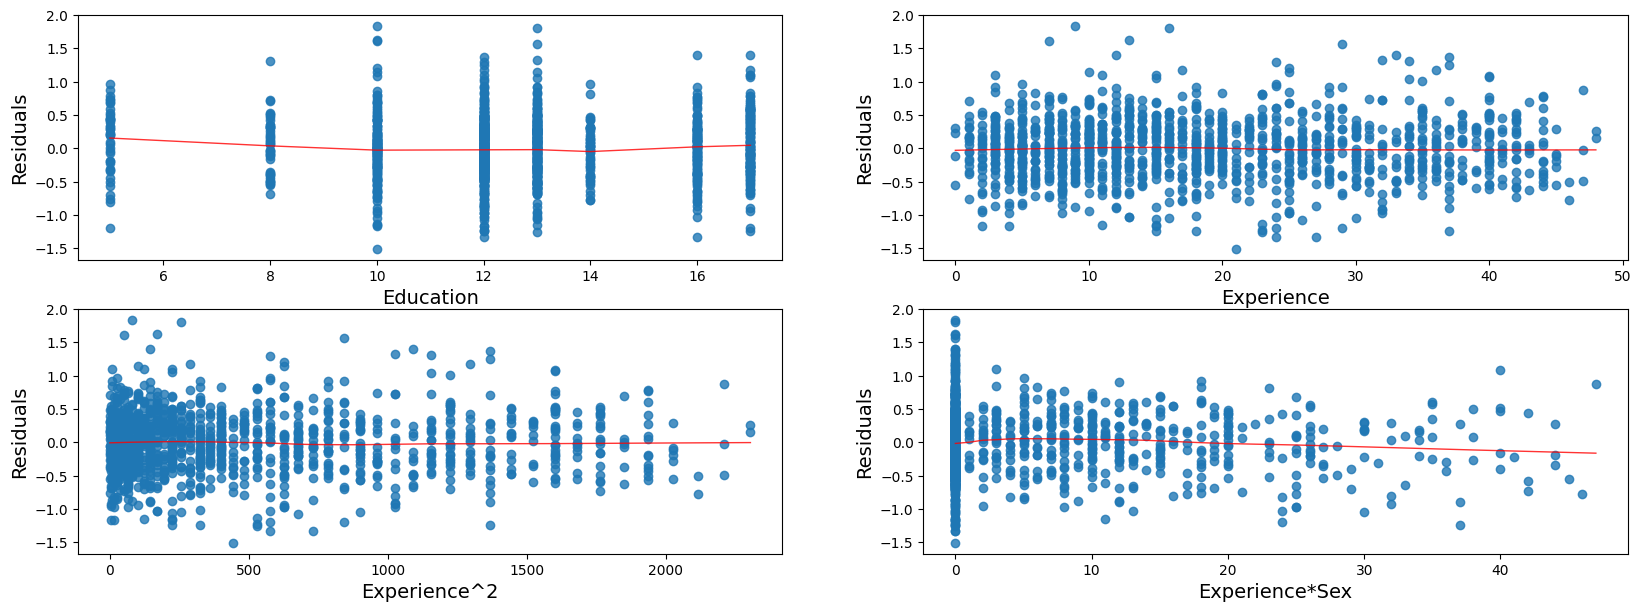

In [78]:
plt.figure(figsize=(20,7))
plt.subplot(221)
sns.regplot(x=data['educ'],y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(222)
sns.regplot(x=data['exper'],y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(223)
sns.regplot(x=data['exper']**2,y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(224)
sns.regplot(x=data['exper']*data['female'],y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience*Sex', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

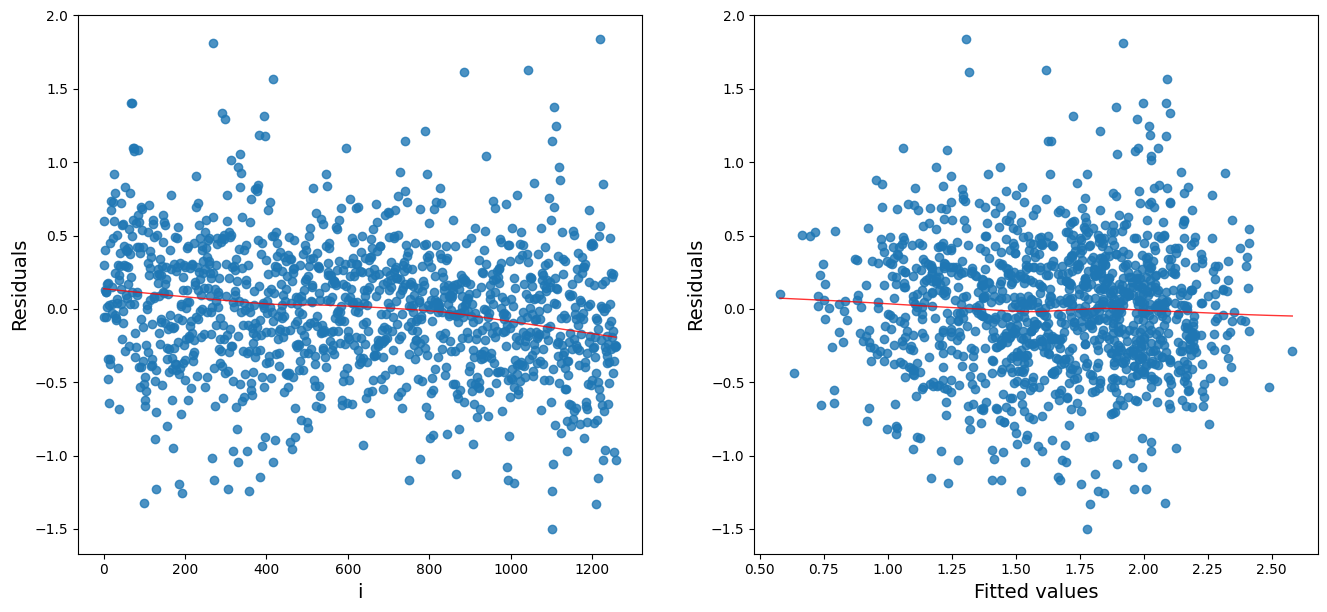

In [80]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(x=np.array(range(len(result_m4.resid))),y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(x=result_m4.fittedvalues,y=result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


## Модель 5


In [81]:
print(result_m4.wald_test('(black = 0)'))

<Wald test (chi2): statistic=[[11.42607985]], p-value=0.0007242032282015889, df_denom=1>


In [82]:
print(result_m4.wald_test('(married  = 0)'))

<Wald test (chi2): statistic=[[4.94331355]], p-value=0.026191779241130166, df_denom=1>


То есть для уровня значимости 0.05 параметр married не значим.

In [83]:
print(result_m4.wald_test('(female:married=0)'))

<Wald test (chi2): statistic=[[10.90747992]], p-value=0.0009577673276387885, df_denom=1>


In [ ]:
print(result_m4.wald_test('(female:black=0)'))

In [85]:
print(result_m4.wald_test('(exper:service=0)'))

<Wald test (chi2): statistic=[[4.30543193]], p-value=0.037990846684764684, df_denom=1>


То есть для уровня значимости 0.05 параметр exper:service не значим. Тогда итоговая модель:

In [86]:
m5 = smf.ols('np.log(wage) ~ exper +'
             'female + black + female * black + female * married +'
             'union + service + educ  + belowavg + np.power(exper,2)', data=data)
result_m5 = m5.fit(cov_type='HC1')
result_m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     91.82
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          4.40e-152
Time:                        19:21:56   Log-Likelihood:                -786.57
No. Observations:                1259   AIC:                             1597.
Df Residuals:                    1247   BIC:                             1659.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3706      0.086      4.298      0.000       0.202       0.540
exper                  0.0389      0.004      9.253      0.000       0.031       0.047
female                -0.3047      0.048     -6.342      0.000      -0.399      -0.211
black                 -0.2443      0.073     -3.332      0.001      -0.388      -0.101
female:black           0.3129      0.099      3.152      0.002       0.118       0.507
married                0.0976      0.040      2.411      0.016       0.018       0.177
female:married        -0.1916      0.057     -3.352      0.001      -0.304      -0.080
union                  0.1758      0.026      6.680      0.000       0.124       0.227
service               -0.1600      0.033     -4.789      0.000      -0.225      -0.094
educ                   0.0755      0.006     13.478      0.000       0.065       0.086
belowavg              -0.1321      0.038     -3.467      0.001      -0.207      -0.057
np.power(exper, 2)    -0.0006   9.36e-05     -6.357      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       25.896   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.309
Skew:                           0.123   Prob(JB):                     8.79e-11
Kurtosis:                       3.907   Cond. No.                     6.64e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Модель 6

### Расстояние Кука

Посмотрим на влиятельные наблюдения:

In [87]:
infl = result_m5.get_influence()
sm_fr = infl.summary_frame()

Text(0, 0.5, 'Cooks distance')

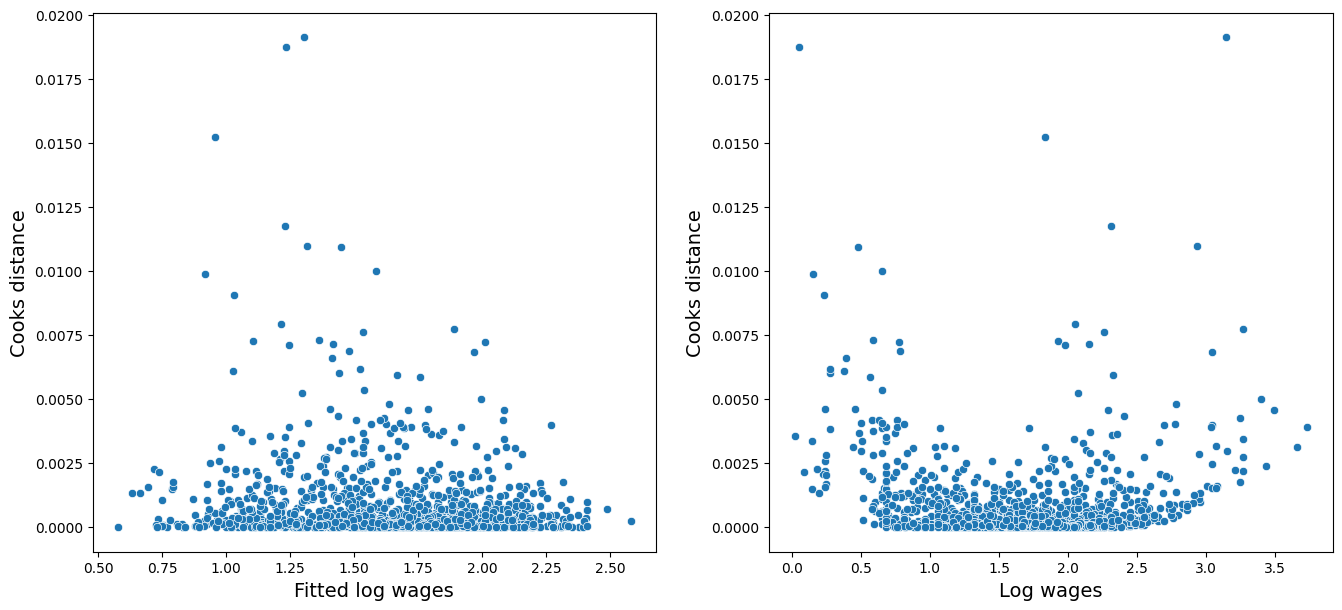

In [89]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.scatterplot(x=result_m4.fittedvalues,y=sm_fr.cooks_d)
plt.xlabel('Fitted log wages', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)
plt.subplot(122)
sns.scatterplot(x=np.log(data.wage),y=sm_fr.cooks_d)
plt.xlabel('Log wages', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)

Удалим наблюдения с расстоянием Кука больше 0.005 (порог выбран визуально) и перенастроим модель 5.

In [94]:
excluded = data[sm_fr.cooks_d > 0.005]
data = data[sm_fr.cooks_d <= 0.015]

In [95]:
m6 = smf.ols('np.log(wage) ~ exper +'
             'female + black + female * black + female * married +'
             'union + service + educ  + belowavg + np.power(exper,2)', data=data)
result_m6 = m6.fit(cov_type='HC1')
result_m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     95.53
Date:                Mon, 08 Apr 2024   Prob (F-statistic):          8.61e-157
Time:                        19:29:30   Log-Likelihood:                -771.76
No. Observations:                1256   AIC:                             1568.
Df Residuals:                    1244   BIC:                             1629.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3405      0.081      4.179      0.000       0.181       0.500
exper                  0.0398      0.004      9.558      0.000       0.032       0.048
female                -0.2845      0.046     -6.217      0.000      -0.374      -0.195
black                 -0.2070      0.070     -2.974      0.003      -0.343      -0.071
female:black           0.2572      0.095      2.702      0.007       0.071       0.444
married                0.1133      0.039      2.930      0.003       0.037       0.189
female:married        -0.2139      0.056     -3.840      0.000      -0.323      -0.105
union                  0.1763      0.026      6.752      0.000       0.125       0.227
service               -0.1681      0.032     -5.206      0.000      -0.231      -0.105
educ                   0.0763      0.005     14.098      0.000       0.066       0.087
belowavg              -0.1283      0.038     -3.380      0.001      -0.203      -0.054
np.power(exper, 2)    -0.0006   9.23e-05     -6.702      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       19.626   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.956
Skew:                           0.085   Prob(JB):                     6.98e-08
Kurtosis:                       3.775   Cond. No.                     6.69e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

некоторые коэффициенты существенно изменились, следовательно, удаление влиятельных наблюдений имело смысл.  

Остатки новой модели:

In [96]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m6.resid, result_m6.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m6.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m6.resid)[1])

Breusch-Pagan test: p=0.000067
Shapiro-Wilk test: p=0.000022
Wilcoxon test: p=0.998635


# Результат

Итоговая модель (№6) построена по 1255 из 1260 исходных объектов и объясняет 41% вариации логарифма отклика:

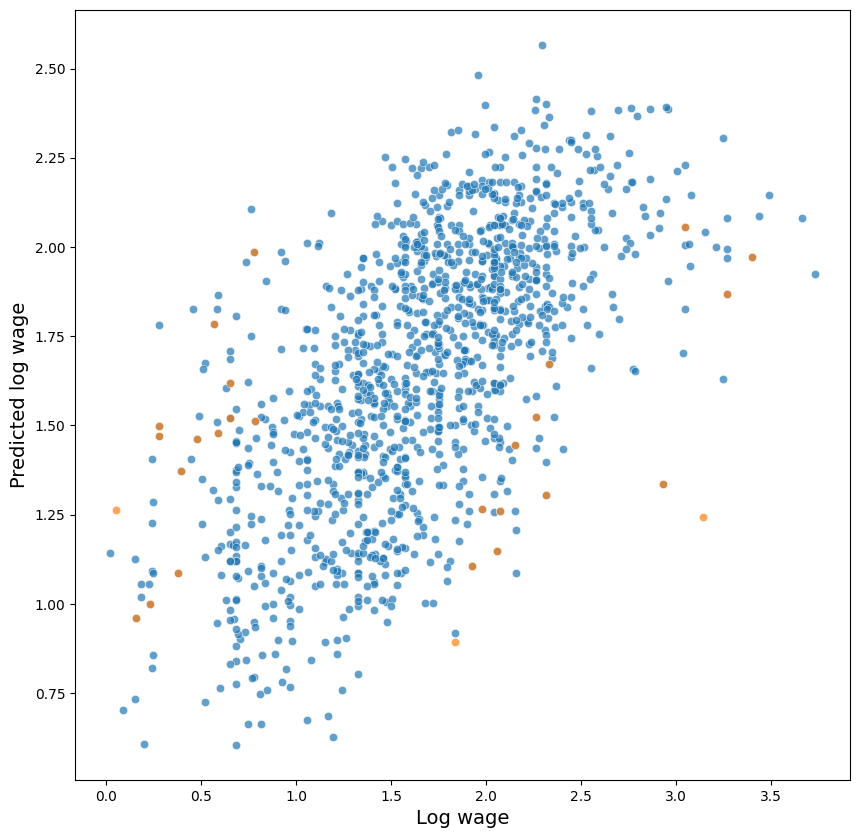

In [102]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=np.log(data.wage),y=result_m6.fittedvalues,alpha=0.7)
sns.scatterplot(x=np.log(excluded.wage),y=result_m6.predict(excluded),alpha=0.7)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predicted log wage', fontsize=14)
plt.show()

С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают на 12% меньше (доверительный интервал (5, 20)%, p=0.001), если их привлекательность ниже средней.